# Pentomino 

总共有12个不同形状的五连体（Pentomino）。

需要把这12个形状放进 $6 \times 10, 5\times 12$ 等不同规格的格子里面，每个格子都必须被填上，不能重复。问总共有多少种放置的方法？

![](../assets/figures/Pentominoes1.png)


See <https://isomerdesign.com/Pentomino/> for detailed result. Not removing duplication in my note!



In [6]:

import numpy as np
from ortools.sat.python import cp_model as cp
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.pyplot import MultipleLocator
import random

COLORS = {
    "F" : "#8CD4C7",
    "I" : "#FFFFB4",
    "L" : "#BFBADA",
    "N" : "#BD7FBD",
    "P" : "#D9D9D9",
    "T" : "#FCB561",
    "U" : "#B3DE68",
    "V" : "#FCCCE5",
    "W" : "#FA7F73",
    "X" : "#7EB0D4",
    "Y" : "#CCEBC4",
    "Z" : "#FFED70"
}

In [7]:
def gen_patterns():
    init_name = "FILNPTUVWXYZ"
    init_Patterns = [
        np.array([
            [0,1,1],
            [1,1,0],
            [0,1,0]
        ]),
        np.array([
            [1],
            [1],
            [1],
            [1],
            [1]
        ]),
        np.array([
            [1,0],
            [1,0],
            [1,0],
            [1,1]
        ]),
        np.array([
            [0,1],
            [1,1],
            [1,0],
            [1,0],
        ]),
        np.array([
            [1,1],
            [1,1],
            [1,0]
        ]),
        np.array([
            [1,1,1],
            [0,1,0],
            [0,1,0]
        ]),
        np.array([
            [1,0,1],
            [1,1,1]
        ]),
        np.array([
            [1,0,0],
            [1,0,0],
            [1,1,1] 
        ]),
        np.array([
            [1,0,0],
            [1,1,0],
            [0,1,1] 
        ]),
        np.array([
            [0,1,0],
            [1,1,1],
            [0,1,0] 
        ]),
        np.array([
            [0,1],
            [1,1],
            [0,1],
            [0,1],
        ]),
        np.array([
            [1,1,0],
            [0,1,0],
            [0,1,1]
        ])
    ]
    all_patterns = []
    pattern_index = []
    all_pattern_temp = []
    for pidx , pattern in enumerate(init_Patterns):
        cnt_idx = 0
        for i in range(1,5):
            pattern_rot = np.rot90(pattern,  k = i, axes = (0,1))
            pattern_flip = np.fliplr(pattern_rot)
            pattern_rot_flag = True 
            pattern_flip_flag = True
            for compare_pattern in all_patterns:
                if pattern_rot_flag and np.array_equal(pattern_rot, compare_pattern):
                    pattern_rot_flag = False 
                if pattern_flip_flag and np.array_equal(pattern_flip, compare_pattern):
                    pattern_flip_flag = False
                if not pattern_rot_flag and not pattern_flip_flag:
                    break
                
            if pattern_rot_flag:
                cnt_idx += 1
                all_patterns.append(pattern_rot)
                pattern_index.append(f"{init_name[pidx]}_{cnt_idx}")
            if pattern_flip_flag and not np.array_equal(pattern_rot, pattern_flip):
                cnt_idx += 1
                all_patterns.append(pattern_flip)
                pattern_index.append(f"{init_name[pidx]}_{cnt_idx}")

    res_all_patterns = dict(zip(pattern_index, all_patterns))
    print(f"# of Pentomino in Total: {len(all_patterns)}")
    return res_all_patterns


# of Pentomino in Total: 63
Start Solving...(Please wait...)
总的摆放数： 8 （没有消重）

CpSolverResponse summary:
status: OPTIMAL
objective: 0
best_bound: 0
integers: 0
booleans: 1236
conflicts: 33583
branches: 223090
propagations: 6617191
integer_propagations: 0
restarts: 2390
lp_iterations: 0
walltime: 2.7224
usertime: 2.7224
deterministic_time: 12.2996
gap_integral: 0
solution_fingerprint: 0xc8c035e13d7eb1b9



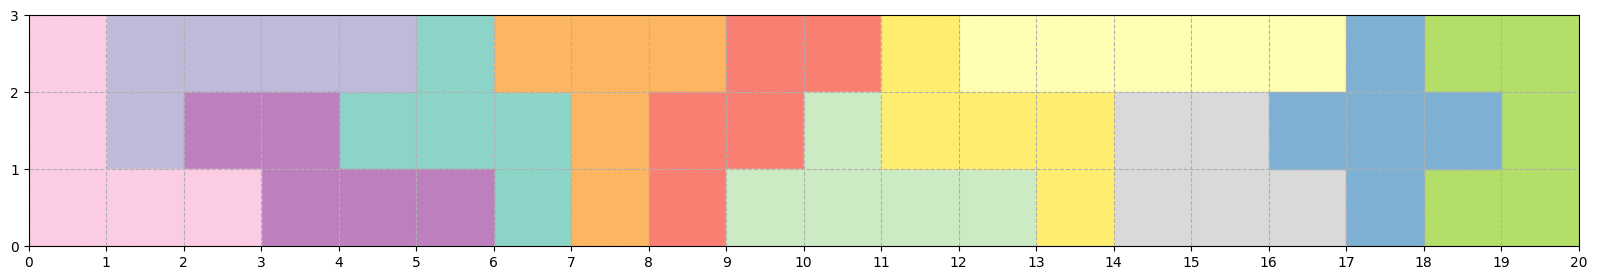

In [8]:
class VarArraySolutionCollector(cp.CpSolverSolutionCallback):

    def __init__(self, variables):
        cp.CpSolverSolutionCallback.__init__(self)
        self.__variables = variables
        self.solution_list = []
        self.solution_sum = 0

    def on_solution_callback(self):
        self.solution_sum += 1
        arx = dict()
        for (k, _) in self.__variables.items():
            if self.Value(self.__variables[k]) > 0.9:
                arx[k[0]] = (k[1], k[2])
        self.solution_list.append(arx)
        # print(self.solution_sum)

class PentominoSolver:
    def __init__(self, X, Y, patterns, grid):
        self.X = X
        self.Y = Y
        self.model = cp.CpModel()
        self.solver = cp.CpSolver() 
        self.patterns = patterns
        self.x = {}
        self.y = {}
        
        assert len(grid) == X * Y
        
        self.grid = grid
        self.avail_variables = {} # 辅助
        self.pattern_choose = {} # 辅助
        self.sol_collector = None # 记录解的字典
        for char_ in "FILNPTUVWXYZ":
            self.pattern_choose[char_] = []
        for i in range(X):
            for j in range(Y):
                if self.grid[i * self.Y  + j] == "0":
                    self.avail_variables[i, j] = []
                    

    
    def removeDuplication(self):
        """_summary_
        消除重复的拼接方式
        """
        pass
    
    def parse2Grid(self, pattern):
        fst, sec = np.where(pattern)
        rows, cols = pattern.shape[0], pattern.shape[1]
        return rows, cols, list(zip(rows - fst - 1, sec))
    
    def check(self, i, j, fill_in_cells):
        """_summary_
        检查是否可以把fill_in_cells的形状放到i,j为左下角的位置里
        """
        for (subxx, subyy) in fill_in_cells:
            if self.grid[(i + subxx) * self.Y + (j + subyy)] == "1":
                # print((i + subxx )* self.Y + (j + subyy))
                # print(fill_in_cells)
                return False
        return True
            
    def solve(self):
        for idx, pattern in self.patterns.items():
            rows, cols, fill_in_cells = self.parse2Grid(pattern)
            # if self.Y % 2 == 0 and self.X % 2 == 0 and idx.startswith("F"):
            #     self.divide = 1
            #     for i in range( (self.X + 1) // 2 - (rows - 1) // 2):
            #         for j in range((self.Y + 1) // 2 - (cols - 1) // 2):
            #             self.x[idx, i, j] = self.model.NewBoolVar(f"x[{idx}_{i}_{j}]")
            #             self.pattern_choose[idx[0]].append(self.x[idx, i, j])
            #             for (subxx, subyy) in fill_in_cells:
            #                 self.avail_variables[i + subxx, j + subyy].append(self.x[idx, i, j])
            # elif self.Y % 2 == 1 and self.X % 2 == 1 and idx.startswith("Y"):
            #     self.divide = 1
            #     for i in range( (self.X + 1) // 2 - (rows - 1) // 2):
            #         for j in range((self.Y + 1) // 2 - (cols - 1) // 2):
            #             self.x[idx, i, j] = self.model.NewBoolVar(f"x[{idx}_{i}_{j}]")
            #             self.pattern_choose[idx[0]].append(self.x[idx, i, j])
            #             for (subxx, subyy) in fill_in_cells:
            #                 self.avail_variables[i + subxx, j + subyy].append(self.x[idx, i, j])
            # else:
            for i in range(self.X - rows + 1):
                for j in range(self.Y - cols + 1):
                    if self.check(i, j, fill_in_cells):
                        self.x[idx, i, j] = self.model.NewBoolVar(f"x[{idx}_{i}_{j}]")
                        self.pattern_choose[idx[0]].append(self.x[idx, i, j])
                        for (subxx, subyy) in fill_in_cells:
                            self.avail_variables[i + subxx, j + subyy].append(self.x[idx, i, j])
                        
            # self.model.Add(sum(current_candidates) == 1)
        for i in range(self.X):
            for j in range(self.Y):
                if self.grid[i * self.Y + j] == "0":
                    self.model.Add(sum(self.avail_variables[i, j]) == 1)
        for key, value in self.pattern_choose.items():
            self.model.Add(sum(value) <= 1 )        
        solution_collector = VarArraySolutionCollector(self.x)
        print("Start Solving...(Please wait...)")
        self.solver.SearchForAllSolutions(self.model, solution_collector)
        self.sol_collector = solution_collector
        print(f"总的摆放数： {self.sol_collector.solution_sum} （没有消重）")
        print(self.solver.SolutionInfo())
        print(self.solver.ResponseStats())
        self.model.ExportToFile("./help2.txt")

    def visualize(self):
        random.seed(123)
        plt.figure(figsize = (self.Y,self.X))
        ax = plt.gca()
        x_major_locator = MultipleLocator(1)
        y_major_locator = MultipleLocator(1)
        ax.xaxis.set_major_locator(x_major_locator)
        # 把x/y轴的主刻度设置为1的倍数
        ax.yaxis.set_major_locator(y_major_locator)
        plt.xlim(0,self.Y)
        plt.ylim(0,self.X)
        plt.grid(linestyle = "--")

        result_idx = random.randint(0, len(self.sol_collector.solution_list))
        
        for i in range(self.X):
            for j in range(self.Y):
                if self.grid[i * self.Y + j] == "1":
                    ax.add_patch(Rectangle((j, i), 1, 1, color = "#02040A"))

        if self.sol_collector.solution_sum > 0:
            sol_c =  self.sol_collector.solution_list[result_idx]
            
            
                        
            for shape, pos in sol_c.items():
                minocolor = COLORS[shape[0]]
                rows, cols, fill_in_cells = self.parse2Grid(self.patterns[shape])
                for sub_cell in fill_in_cells:
                    ax.add_patch(Rectangle((sub_cell[1] + pos[1], sub_cell[0] + pos[0]), 1, 1, color = minocolor))

        plt.savefig(f"../assets/figures/Pentomino/result_{self.X}x{self.Y}_{result_idx}.png")

if __name__ == "__main__":
    res_all_patterns = gen_patterns()
    grid = "0000000000000000000000000001100000011000000000000000000000000000" # 8x8a
    grid = "0000000000000000100000000000000110000000000000010000000000000000" # 4x16d
    grid = "0000000000000000001000000000010000100000000001000000000000000000" # 4x16 Not feasible
    grid = "111000111111000111111000111000000111000000111000000111111000000111000000111000000" # 9x9 
    grid = "111000111111000111111000111000000000000000000000000000111000111111000111111000111"
    grid = "000000000000000000000000000000000000000000000000000000000000"
    PentominoSolverTest = PentominoSolver(3, 20, res_all_patterns, grid = grid)
    
    PentominoSolverTest.solve()
    PentominoSolverTest.visualize()
    

